# **Sentimen Analisis Review APK Canva dari Play Store**

## **Import Library**

In [35]:
# Manipulasi data
import pandas as pd
pd.options.mode.chained_assignment = None  # Menonaktifkan peringatan chaining
import numpy as np
import datetime as dt
import csv
import requests
from io import StringIO

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Pemrosesan teks
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocessing dan encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Evaluasi model
from sklearn.metrics import accuracy_score, classification_report

# Keras & TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, Bidirectional, GRU,
    Dense, Dropout, Conv1D, GlobalMaxPooling1D,
    BatchNormalization, GlobalAveragePooling1D
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2

# Reproducibility
seed = 0
np.random.seed(seed)


In [36]:
!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Stemming (penghilangan imbuhan kata) dalam bahasa Indonesia
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Menghapus kata-kata berhenti dalam bahasa Indonesia


In [37]:
import nltk  # Import pustaka NLTK (Natural Language Toolkit).
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stopwords) dalam berbagai bahasa.
nltk.download('punkt_tab') # Mengunduh file tambahan yang digunakan oleh modul 'punkt' untuk mempercepat pemrosesan tokenisasi.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## **Loading Dataset**

In [38]:
review_canva_df = pd.read_csv('https://raw.githubusercontent.com/qnyara5/Analisis-Sentimen-Review-APKGOPAY-/f42024f40a55abc6957bf59d72e267c8c99bca36/data/canva_reviews_cleaned.csv')
review_canva_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,be62dda0-4bc2-43ff-ae46-ef4df55f4ce5,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"4 dulu yaa, punya ku ko opsi galeri nya cuma a...",4,8,2.308.0,2025-04-22 13:09:49,"Halo Padillhan, terima kasih atas masukan Anda...",2025-04-24 07:03:51,2.308.0
1,6b37ee2e-30b6-4168-8a1c-eb7fc9c0966f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Gila bugg nya, loading di proyek 2 menit seten...",4,2,2.308.0,2025-04-22 11:03:18,"Hai Nurdiyansah, terima kasih telah menggunaka...",2025-04-23 11:20:35,2.308.0
2,a887be29-6865-4388-ad12-acca9a616efe,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,asli kenapa makin di update makin gak bagus tr...,1,3,2.306.1,2025-04-19 05:57:04,"Hai Muhammad, terima kasih telah menghubungi C...",2025-04-21 01:57:58,2.306.1
3,e1e5c544-59b9-4b38-8fb2-3470f1df3d58,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasi nya tidak bisa dibuka untuk di bebera...,1,30,2.306.1,2025-04-12 03:01:41,"Halo Dheas, terima kasih telah menghubungi Can...",2025-04-14 06:41:56,2.306.1
4,976e8f99-a7bc-419c-9958-d260fe33b903,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Setelah update, Canva ada bug. Biasanya saat m...",3,37,2.306.0,2025-04-04 05:28:47,"Hai Natalia, terima kasih telah menghubungi Ca...",2025-04-06 02:32:24,2.306.0
...,...,...,...,...,...,...,...,...,...,...,...
35700,12f057ea-030a-4709-ac59-5c05a5330306,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Mohon bantuannya dong. Untuk tambah gambar dar...,4,0,1.0.0,2017-12-09 00:00:42,Hai di sana! Terima kasih atas penilaiannya. M...,2017-12-21 13:52:32,1.0.0
35701,43c6aa82-e4e6-4aa9-94dc-312c6d587d8a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Gimana cara nyimpen cover yang udah selesai ke...,2,3,1.0.0,2017-11-30 11:05:51,"Halo! Kami ingin membantu; Namun, kami memerlu...",2017-12-14 15:47:36,1.0.0
35702,32c553a8-9096-45cf-980e-ba7c2bad5ffe,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Tambah fitur custom size page please,4,1,1.0.0,2017-12-06 01:25:27,"Hai Ivan, Kami mendengar Anda. Tim kami masih ...",2017-12-17 22:44:25,1.0.0
35703,434352a8-7334-4f0d-b597-a00cd8140a87,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Kenapa aplikasinya ga bisa dibuka? Selalu keluar,2,0,1.0.0,2017-12-11 10:57:03,Maaf mendengar Anda mengalami masalah saat mem...,2017-12-24 04:29:55,1.0.0


In [39]:
# Mengambil 15.000 data secara acak dari dataframe
review_canva_df = review_canva_df.sample(n=18000, random_state=42).reset_index(drop=True)

# Menampilkan dataframe hasil sampling
review_canva_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,89d32a88-e4c4-48db-9134-83f559840ccf,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,bagus banget woe,4,0,2.187.0,2022-10-19 07:36:24,"Halo Ichaseptika, terima kasih atas umpan bali...",2022-10-26 20:23:03,2.187.0
1,8cb96289-2a51-4516-96b8-498a52de4920,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Lelet teruss, pdhl jaringan saya normal normal...",2,1,2.249.0,2024-02-06 01:22:08,"Hai Jahra, terima kasih telah menggunakan Canv...",2024-02-07 19:01:04,2.249.0
2,3e5c7924-37c5-4ec2-ba16-b515589b8018,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,coba dulu yah,1,0,2.13.0,2019-05-17 15:21:32,"Hai Pae, kami ingin membuat segalanya lebih ba...",2019-08-14 07:21:38,2.13.0
3,6343c18a-f106-484c-915d-06d2f3c0bab7,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"sangat membantu sekali, terimakasih",4,0,2.128.0,2021-09-18 07:46:28,"Halo Fericha, terima kasih atas tanggapan Anda...",2021-09-24 13:25:31,2.128.0
4,e1732dff-43f5-4698-a23d-7c5a072cb83a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Kenapa ya canva nya kok susah di perbarui pada...,2,0,2.209.0,2023-05-14 05:48:08,"Hai Anisa, terima kasih telah menggunakan Canv...",2023-05-16 07:05:46,2.209.0
...,...,...,...,...,...,...,...,...,...,...,...
17995,fce174bf-cd58-44cb-818e-947d36e2aa29,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tingkat lagi masih suka lag,4,0,2.4.2,2019-03-04 11:55:00,"Hai sana, terima kasih kerana menjatuhkan untu...",2019-03-05 09:11:14,2.4.2
17996,192e703d-4ef9-4108-a5a1-df506ed9f767,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Ok bagus,3,0,2.218.0,2023-06-28 20:44:39,"Halo Herlina, terima kasih atas tanggapan Anda...",2023-06-30 22:59:08,2.218.0
17997,7d288ff3-7d01-46a1-80e1-fa4e82f29471,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasinya bagus bangeeet ga kecewa,4,0,2.166.0,2022-05-30 15:17:13,"Halo, terima kasih atas kata-kata yang baik. T...",2022-05-31 23:58:38,2.166.0
17998,b1c8a235-177c-4f97-8cba-1c4e84e84ed6,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Semuanya oke, hanya saja jika gambar sudah dis...",5,0,1.8.1,2018-10-04 09:00:13,Hai. Kami sudah bekerja pada kemampuan untuk m...,2018-10-03 16:55:38,1.8.1


In [40]:
# Menampilkan informasi tentang DataFrame app_reviews_df
review_canva_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              18000 non-null  object
 1   userName              18000 non-null  object
 2   userImage             18000 non-null  object
 3   content               18000 non-null  object
 4   score                 18000 non-null  int64 
 5   thumbsUpCount         18000 non-null  int64 
 6   reviewCreatedVersion  18000 non-null  object
 7   at                    18000 non-null  object
 8   replyContent          18000 non-null  object
 9   repliedAt             18000 non-null  object
 10  appVersion            18000 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.5+ MB


## **Preprocessing**

In [41]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [42]:
slangwords = {
    "@": "di",
    "abis": "habis",
    "wtb": "beli",
    "wts": "jual",
    "wtt": "tukar",
    "bgt": "banget",
    "bnget": "banget",
    "banget": "sekali",
    "maks": "maksimal",
    "masi": "masih",
    "ga": "tidak",
    "gak": "tidak",
    "gk": "tidak",
    "ngga": "tidak",
    "nggak": "tidak",
    "tdk": "tidak",
    "dak": "tidak",
    "gausah": "tidak usah",
    "gajelas": "tidak jelas",
    "aja": "saja",
    "doang": "saja",
    "doaank": "saja",
    "ajaib": "aneh",
    "kok": "mengapa",
    "koq": "kok",
    "ko": "kok",
    "bikin": "membuat",
    "ngerti": "mengerti",
    "krn": "karena",
    "karna": "karena",
    "dr": "dari",
    "dri": "dari",
    "yg": "yang",
    "yng": "yang",
    "dgn": "dengan",
    "sm": "sama",
    "sama2": "sama-sama",
    "udh": "sudah",
    "udah": "sudah",
    "dah": "sudah",
    "sudahh": "sudah",
    "blm": "belum",
    "blom": "belum",
    "td": "tadi",
    "tdi": "tadi",
    "lg": "lagi",
    "lagi2": "lagi-lagi",
    "dl": "dulu",
    "tp": "tapi",
    "trus": "terus",
    "trs": "terus",
    "teruss": "terus",
    "bbrp": "beberapa",
    "bs": "bisa",
    "bsa": "bisa",
    "kyk": "seperti",
    "kaya": "seperti",
    "sprti": "seperti",
    "jg": "juga",
    "jga": "juga",
    "nih": "ini",
    "nyoba": "mencoba",
    "nyobain": "mencoba",
    "nyobak": "mencoba",
    "nyobanya": "mencoba",
    "nanya": "bertanya",
    "kena": "terkena",
    "ngasih": "memberi",
    "ngasi": "memberi",
    "kasih": "memberi",
    "ampe": "sampai",
    "sampe": "sampai",
    "smpe": "sampai",
    "makasih": "terima kasih",
    "makasi": "terima kasih",
    "makasii": "terima kasih",
    "thanks": "terima kasih",
    "thx": "terima kasih",
    "tq": "terima kasih",
    "pls": "please",
    "plz": "please",
    "knp": "kenapa",
    "kenape": "kenapa",
    "napa": "kenapa",
    "np":"kenapa",
    "msuk": "masuk",
    "tlong": "tolong",
    "tolongin": "tolong",
    "ilang": "hilang",
    "bintang": "rating",
    "parah": "buruk",
    "pelayanannya": "pelayanannya",
    "gopaylater": "gopay later",
    "cs": "customer service",
    "dtg": "datang",
    "gmn": "bagaimana",
    "gmn?": "bagaimana",
    "cm": "cuma",
    "cuma": "hanya",
    "cmn": "cuman",
    "cuman": "hanya",
    "bbrp": "beberapa",
    "dpt": "dapat",
    "dapet": "dapat",
    "dpet": "dapat",
    "aja": "saja",
    "skrg": "sekarang",
    "skrng": "sekarang",
    "ntar": "nanti",
    "entar": "nanti",
    "bgtu": "begitu",
    "gtu": "begitu",
    "bangsat": "kasar",
    "anjing": "kasar",
    "kampret": "kasar",
    "lebay": "berlebihan",
    "ngebug": "bermasalah",
    "buggy": "bermasalah",
    "lemot": "lambat",
    "ngelag": "lambat",
    "laggy": "lambat",
    "ngedown": "tidak bisa digunakan",
    "ngehang": "macet",
    "ngefreeze": "beku",
    "gituu": "begitu",
    "ni": "ini",
    "ituu": "itu",
    "niih": "ini",
    "yaa": "ya",
    "ajaa": "saja",
    "klo": "kalau",
    "klw": "kalau",
    "kl": "kalau",
    "udh2an": "sudahan",
    "brg": "barang",
    "barangnya": "barangnya",
    "brng": "barang",
    "ky": "seperti",
    "pdhl": "padahal",
    "mlh": "malah",
    "smua": "semua",
    "semuanya": "semua",
    "org": "orang",
    "orang2": "orang-orang",
    "org2": "orang-orang",
    "syukron": "terima kasih",
    "thx": "terima kasih",
    "makasihh": "terima kasih",
    "makasii": "terima kasih",
    "makasi": "terima kasih",
    "yaudah": "sudah",
    "udh": "sudah",
    "yuk": "ayo",
    "ayo": "ayo",
    "krn": "karena",
    "karn": "karena",
    "tp": "tapi",
    "trus": "terus",
    "trs": "terus",
    "trusss": "terus",
    "ntar": "nanti",
    "ntar2": "nanti",
    "skrg": "sekarang",
    "sekarangg": "sekarang",
    "jgn": "jangan",
    "jgn2": "jangan",
    "jgnngg": "jangan",
    "gpp": "gak apa-apa",
    "gapapa": "gak apa-apa",
    "gakapa": "gak apa-apa",
    "gpp": "gak apa-apa",
    "msh": "masih",
    "masihh": "masih",
    "sory": "maaf",
    "sorry": "maaf",
    "sori": "maaf",
    "maap": "maaf",
    "gausah": "tidak usah",
    "gkusah": "tidak usah",
    "gakusah": "tidak usah",
    "ga": "tidak",
    "gak": "tidak",
    "nggak": "tidak",
    "engga": "tidak",
    "cuy": "bro",
    "bro": "saudara",
    "sista": "saudari",
    "dunno": "tidak tahu",
    "tunya": "punya",
    "punyaa": "punya",
    "lagi": "lagi",
    "lg": "lagi",
    "lagii": "lagi",
    "lt": "latihan",
    "otw": "on the way",
    "gas": "cepat",
    "gass": "cepat",
    "next": "berikutnya",
    "gimana": "bagaimana",
    "gmn": "bagaimana",
    "komplain": "keluhan",
    "komplainnya": "keluhannya",
    "gimanaa": "bagaimana",
    "ahh": "ah",
    "wow": "wow",
    "yaampun": "ya ampun",
    "apaan": "apa",
    "apaa": "apa",
    "apaan2": "apa-apa",
    "dongo": "bodoh",
    "gedek": "kesal",
    "greget": "kesal",
    "gergetan": "kesal",
    "baper": "bawa perasaan",
    "baperr": "bawa perasaan",
    "galau": "bingung",
    "kepo": "ingin tahu",
    "ngelantur": "berbicara tidak jelas",
    "kece": "keren",
    "kerenn": "keren",
    "kerens": "keren",
    "banget": "sekali",
    "bgt": "banget",
    "ngegas": "memaksakan",
    "teteh": "kakak",
    "demen": "suka",
    "suke": "suka",
    "gaenak": "tidak enak",
    "enakk": "enak",
    "seru": "menyenangkan",
    "seruuu": "menyenangkan",
    "kocak": "lucu",
    "gokil": "lucu",
    "ngakak": "terbahak-bahak",
    "jangankan": "apalagi",
    "ndeso": "kampungan",
    "nkesel": "kesel",
    "soale": "soalnya",
    "jerr": "jarang",
    "ngecut": "membatalkan",
    "nusuk": "menusuk",
    "milih": "memilih",
    "ngekek": "terpingkal-pingkal",
    "ngomel": "mempersalahkan",
    "terlalu": "terlalu",
    "sesuatu": "sesuatu",
    "caper": "cari perhatian",
    "baperan": "bawa perasaan",
    "masi": "masih",
    "ngerasa": "merasa",
    "nanya": "bertanya",
    "cuwek": "cuek",
    "jadiin": "jadikan",
    "ngobrol": "berbicara",
    "ngumpul": "berkumpul",
    "dapet": "mendapatkan",
    "makasihh": "terima kasih",
    "mehong": "mahal",
    "kentang": "buruk",
    "ndak": "tidak",
    "ngga": "tidak",
    "gaes": "teman",
    "gaess": "teman",
    "ajg": "anjing",
    "anj": "anjing",
    "bgst": "bangsat",
    "anjrit": "anjing",
    "anjay": "anjing",
    "btw": "ngomong-ngomong",
    "br": "baru",
    "bru": "baru",
    "bkn": "bukan",
    "bukanx": "bukan",
    "dlm": "dalam",
    "lu": "kamu",
    "elo": "kamu",
    "loe": "kamu",
    "lo": "kamu",
    "gw": "saya",
    "gue": "saya",
    "gua": "saya",
    "ak": "aku",
    "aq": "aku",
    "sy": "saya",
    "dy": "dia",
    "doi": "dia",
    "trs2": "terus-terusan",
    "x": "kali",
    "jd": "jadi",
    "jdi": "jadi",
    "jdinya": "jadinya",
    "jgk": "juga",
    "skalian": "sekalian",
    "trkadang": "terkadang",
    "km": "kamu",
    "kmrn": "kemarin",
    "kmren": "kemarin",
    "kmn": "kemana",
    "klian": "kalian",
    "klianya": "kaliannya",
    "plis": "please",
    "pliiss": "please",
    "trima": "terima",
    "trmksih": "terima kasih",
    "trmksh": "terima kasih",
    "thn": "tahun",
    "bln": "bulan",
    "hr": "hari",
    "mlm": "malam",
    "siang2": "siang-siang",
    "pagi2": "pagi-pagi",
    "maleman": "malam-malam",
    "cewe": "perempuan",
    "cewek": "perempuan",
    "cowo": "laki-laki",
    "cowok": "laki-laki",
    "bokap": "ayah",
    "nyokap": "ibu",
    "ortu": "orang tua",
    "tmn": "teman",
    "temen": "teman",
    "tmn2": "teman-teman",
    "mantul": "mantap betul",
    "gila": "hebat",
    "gilee": "hebat",
    "mantapdjiwa": "mantap jiwa",
    "santuy": "santai",
    "mager": "malas gerak",
    "gabut": "tidak ada kerjaan",
    "julid": "sirik",
    "halu": "halusinasi",
    "salty": "tersinggung",
    "baper": "bawa perasaan",
    "bawa2": "membawa-bawa",
    "ngegas": "marah",
    "ngambek": "marah",
    "ngeyel": "keras kepala",
    "lebai": "berlebihan",
    "alay": "berlebihan",
    "pd": "pada",
    "lbh": "lebih",
    "bnyk": "banyak",
    "dikit": "sedikit",
    "sgt": "sangat",
    "pgn": "ingin",
    "pngn": "ingin",
    "mauu": "mau",
    "jgak": "juga",
    "pdhl": "padahal",
    "sbnrnya": "sebenarnya",
    "sbenernya": "sebenarnya",
    "kepingin": "ingin",
    "kyknya": "sepertinya",
    "skrg": "sekarang",
    "bsok": "besok",
    "ntn": "nonton",
    "liat": "melihat",
    "ngeliat": "melihat",
    "ngeliatin": "melihat",
    "liatin": "melihat",
    "liat2": "melihat-lihat",
    "tpn": "tapi",
    "trkdg": "terkadang",
    "trkdg2": "terkadang-kadang",
    "ni": "ini",
    "nihh": "ini",
    "ituh": "itu",
    "bgtu": "begitu",
    "gt": "begitu",
    "gitu": "begitu",
    "gituan": "seperti itu",
    "gth": "begitu",
    "bangett": "sekali",
    "bngt": "banget",
    "dlm": "dalam",
    "lu": "kamu",
    "loe": "kamu",
    "lo": "kamu",
    "elu": "kamu",
    "gua": "saya",
    "gw": "saya",
    "gue": "saya",
    "ak": "aku",
    "aq": "aku",
    "sy": "saya",
    "ane": "saya",
    "trs2an": "terus-terusan",
    "trus2": "terus-terus",
    "ky": "seperti",
    "sprt": "seperti",
    "udh2": "sudahan",
    "ngaruh": "berpengaruh",
    "ngaruhnya": "pengaruhnya",
    "kn": "kan",
    "kan?": "bukan?",
    "lahh": "lah",
    "lha": "lah",
    "ajaib": "aneh",
    "pd": "pada",
    "aja2": "saja-saja",
    "sbnrnya": "sebenarnya",
    "sbnr": "sebenarnya",
    "sbnarnya": "sebenarnya",
    "tdk": "tidak",
    "tdkkk": "tidak",
    "blum": "belum",
    "blomm": "belum",
    "tdi": "tadi",
    "tdian": "tadi",
    "dmn": "di mana",
    "dimn": "di mana",
    "dimana": "di mana",
    "dlu": "dulu",
    "duluu": "dulu",
    "lbh": "lebih",
    "lebihh": "lebih",
    "drpd": "daripada",
    "daripd": "daripada",
    "utk": "untuk",
    "untukk": "untuk",
    "utkmu": "untukmu",
    "smpt": "sempat",
    "sempet": "sempat",
    "tdk": "tidak",
    "smw": "semua",
    "semw": "semua",
    "ksh": "kasih",
    "kasii": "kasih",
    "kasi": "kasih",
    "duh": "aduh",
    "aduhh": "aduh",
    "dg": "dengan",
    "bwt": "buat",
    "buat2": "membuat-membuat",
    "btw": "ngomong-ngomong",
    "cm": "cuma",
    "cma": "cuma",
    "pgn": "ingin",
    "pingin": "ingin",
    "pengen": "ingin",
    "mauu": "mau",
    "mang": "memang",
    "emg": "memang",
    "emang": "memang",
    "jd": "jadi",
    "jdii": "jadi",
    "jdinya": "jadinya",
    "sblm": "sebelum",
    "seblum": "sebelum",
    "abisin": "habiskan",
    "abis2": "habis-habis",
    "mnt": "menit",
    "mntn": "menonton",
    "tlg": "tolong",
    "tolongin": "tolong",
    "cpt": "cepat",
    "cepet": "cepat",
    "cepattt": "cepat",
    "brpa": "berapa",
    "brp": "berapa",
    "brpaan": "berapa-berapa",
    "ntr": "nanti",
    "mls": "malas",
    "males": "malas",
    "cape": "capai",
    "capek": "capai",
    "capekk": "capai",
    "knp": "kenapa",
    "napa": "kenapa",
    "napaa": "kenapa",
    "ngapa": "kenapa",
    "kenapaa": "kenapa",
    "dongo": "bodoh",
    "bege": "bodoh",
    "lemottt": "lambat",
    "bug": "masalah",
    "ngebug": "bermasalah",
    "lag": "lambat",
    "ngelag": "lambat",
    "gbs": "tidak bisa",
    "gabs": "tidak bisa",
    "gtw": "tidak tahu",
    "gatw": "tidak tahu",
    "ribet": "rumit",
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [43]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
review_canva_df['text_clean'] = review_canva_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
review_canva_df['text_casefoldingText'] = review_canva_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
review_canva_df['text_slangwords'] = review_canva_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
review_canva_df['text_tokenizingText'] = review_canva_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
review_canva_df['text_stopword'] = review_canva_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
review_canva_df['text_akhir'] = review_canva_df['text_stopword'].apply(toSentence)

# Menampilkan data
review_canva_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,89d32a88-e4c4-48db-9134-83f559840ccf,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,bagus banget woe,4,0,2.187.0,2022-10-19 07:36:24,"Halo Ichaseptika, terima kasih atas umpan bali...",2022-10-26 20:23:03,2.187.0,bagus banget woe,bagus banget woe,bagus sekali woe,"[bagus, sekali, woe]","[bagus, woe]",bagus woe
1,8cb96289-2a51-4516-96b8-498a52de4920,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Lelet teruss, pdhl jaringan saya normal normal...",2,1,2.249.0,2024-02-06 01:22:08,"Hai Jahra, terima kasih telah menggunakan Canv...",2024-02-07 19:01:04,2.249.0,Lelet teruss pdhl jaringan saya normal normal ...,lelet teruss pdhl jaringan saya normal normal ...,lelet terus padahal jaringan saya normal norma...,"[lelet, terus, padahal, jaringan, saya, normal...","[lelet, jaringan, normal, normal, pas, ngetes,...",lelet jaringan normal normal pas ngetes jaring...
2,3e5c7924-37c5-4ec2-ba16-b515589b8018,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,coba dulu yah,1,0,2.13.0,2019-05-17 15:21:32,"Hai Pae, kami ingin membuat segalanya lebih ba...",2019-08-14 07:21:38,2.13.0,coba dulu yah,coba dulu yah,coba dulu yah,"[coba, dulu, yah]","[coba, yah]",coba yah
3,6343c18a-f106-484c-915d-06d2f3c0bab7,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"sangat membantu sekali, terimakasih",4,0,2.128.0,2021-09-18 07:46:28,"Halo Fericha, terima kasih atas tanggapan Anda...",2021-09-24 13:25:31,2.128.0,sangat membantu sekali terimakasih,sangat membantu sekali terimakasih,sangat membantu sekali terimakasih,"[sangat, membantu, sekali, terimakasih]","[membantu, terimakasih]",membantu terimakasih
4,e1732dff-43f5-4698-a23d-7c5a072cb83a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Kenapa ya canva nya kok susah di perbarui pada...,2,0,2.209.0,2023-05-14 05:48:08,"Hai Anisa, terima kasih telah menggunakan Canv...",2023-05-16 07:05:46,2.209.0,Kenapa ya canva nya kok susah di perbarui pada...,kenapa ya canva nya kok susah di perbarui pada...,kenapa ya canva nya mengapa susah di perbarui ...,"[kenapa, ya, canva, nya, mengapa, susah, di, p...","[canva, susah, perbarui, diulang, kali]",canva susah perbarui diulang kali
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,fce174bf-cd58-44cb-818e-947d36e2aa29,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tingkat lagi masih suka lag,4,0,2.4.2,2019-03-04 11:55:00,"Hai sana, terima kasih kerana menjatuhkan untu...",2019-03-05 09:11:14,2.4.2,tingkat lagi masih suka lag,tingkat lagi masih suka lag,tingkat lagi masih suka lambat,"[tingkat, lagi, masih, suka, lambat]","[tingkat, suka, lambat]",tingkat suka lambat
17996,192e703d-4ef9-4108-a5a1-df506ed9f767,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Ok bagus,3,0,2.218.0,2023-06-28 20:44:39,"Halo Herlina, terima kasih atas tanggapan Anda...",2023-06-30 22:59:08,2.218.0,Ok bagus,ok bagus,ok bagus,"[ok, bagus]","[ok, bagus]",ok bagus
17997,7d288ff3-7d01-46a1-80e1-fa4e82f29471,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasinya bagus bangeeet ga kecewa,4,0,2.166.0,2022-05-30 15:17:13,"Halo, terima kasih atas kata-kata yang baik. T...",2022-05-31 23:58:38,2.166.0,Aplikasinya bagus bangeeet ga kecewa,aplikasinya bagus bangeeet ga kecewa,aplikasinya bagus bangeeet tidak kecewa,"[aplikasinya, bagus, bangeeet, tidak, kecewa]","[aplikasinya, bagus, bangeeet, kecewa]",aplikasinya bagus bangeeet kecewa
17998,b1c8a235-177c-4f97-8cba-1c4e84e84ed6,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Semuanya oke, hanya saja jika gambar sudah dis...",5,0,1.8.1,2018-10-04 09:00:13,Hai. Kami sudah bekerja pada kemampuan untuk m...,2018-10-03 16:55:38,1.8.1,Semuanya oke hanya saja jika gamb

## **Pelabelan**

In [44]:
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [45]:
# Fungsi untuk menentukan polaritas sentimen dari teks menggunakan pendekatan leksikon
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    # Inisialisasi skor sentimen ke 0

    for word in text:
        # Mengulangi setiap kata dalam teks
        if word in lexicon_positive:
            score += lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks lagi
        if word in lexicon_negative:
            score += lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, tambahkan (dengan nilai negatif) ke skor sentimen

    polarity = ''
    # Menentukan polaritas berdasarkan skor
    if score > 0:
        polarity = 'positive'
    elif score < -1:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity
    # Mengembalikan nilai skor dan polaritas teks


In [46]:
results = review_canva_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
review_canva_df['polarity_score'] = results[0]
review_canva_df['polarity'] = results[1]
print(review_canva_df['polarity'].value_counts())

polarity
neutral     6288
positive    6034
negative    5678
Name: count, dtype: int64


## **Explorasi Data**

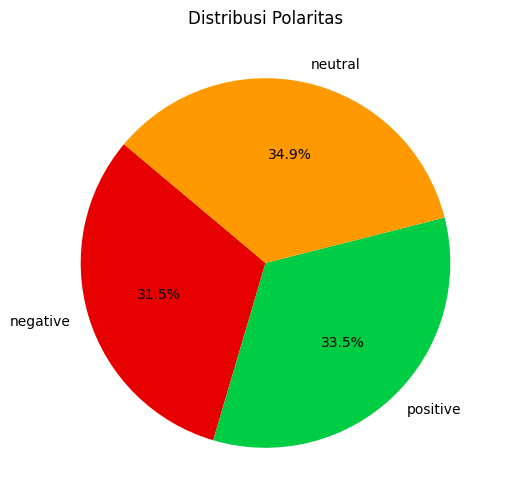

In [47]:
# --- PIE CHART ---
color_map = {
    'negative': '#e60000',  # merah
    'positive': '#00cc44',  # hijau
    'neutral': '#ff9900'    # oranye
}

# Ambil distribusi label dengan urutan yang konsisten
label_counts = review_canva_df['polarity'].value_counts().reindex(['negative', 'positive', 'neutral'])

plt.figure(figsize=(6, 6))
label_counts.plot.pie(
    autopct='%1.1f%%',
    colors=[color_map[label] for label in label_counts.index],
    startangle=140
)
plt.title('Distribusi Polaritas')
plt.ylabel('')
plt.show()


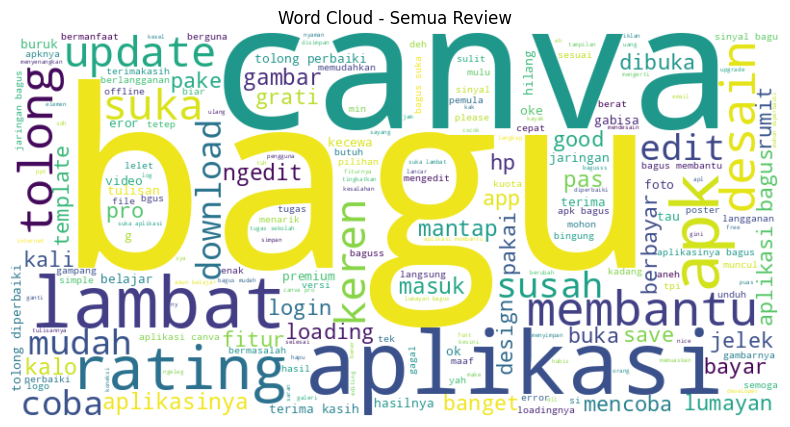

In [48]:
# --- WORDCLOUD UMUM ---
list_words = ''

for tweet in review_canva_df['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(list_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Semua Review")
plt.show()

In [49]:
# --- WORDCLOUD PER SENTIMEN (diperbaiki) ---
def generate_wordcloud(label, title):
    list_words = ''
    # Filter hanya review dengan polarity tertentu
    filtered = review_canva_df[review_canva_df['polarity'] == label]

    # Gabungkan kata-kata dari list token
    for tweet in filtered['text_stopword']:
        for word in tweet:
            list_words += ' ' + word

    # Buat dan tampilkan WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(list_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()


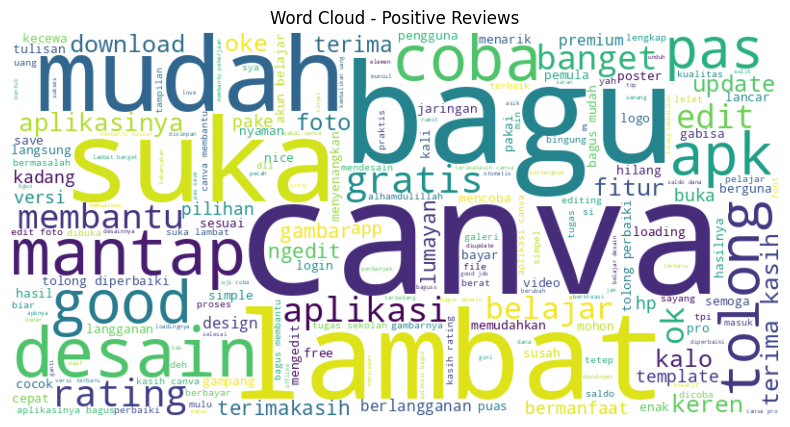

In [50]:
# --- WORDCLOUD SENTIMEN POSITIVE ---
generate_wordcloud('positive', "Word Cloud - Positive Reviews")

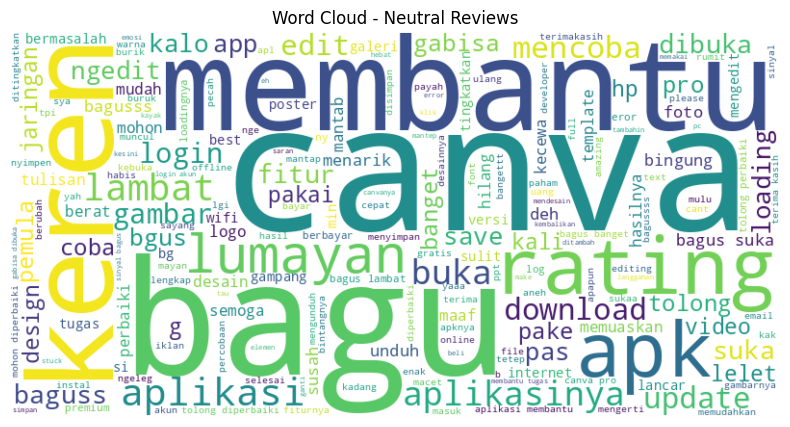

In [51]:
# --- WORDCLOUD SENTIMEN NEUTRAL ---
generate_wordcloud('neutral', "Word Cloud - Neutral Reviews")

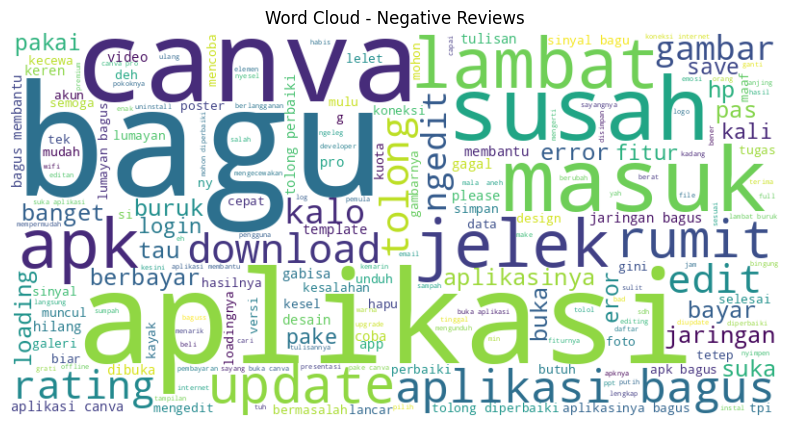

In [52]:
# --- WORDCLOUD SENTIMEN NEGATIVE---
generate_wordcloud('negative', "Word Cloud - Negative Reviews")

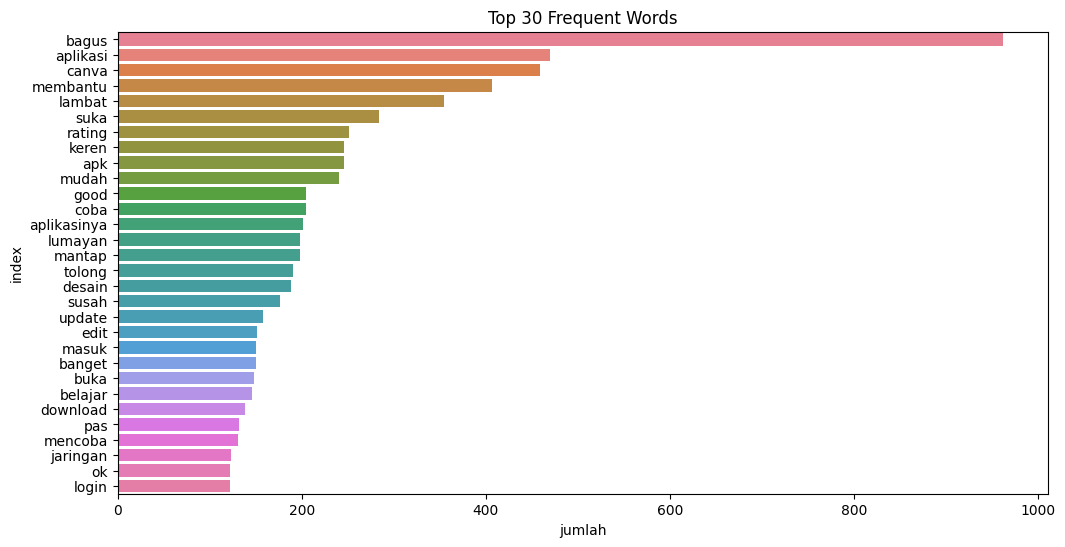

In [53]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Visualize most frequent words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(review_canva_df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(30)
sns.barplot(x='jumlah', y='index', data=tfidf_df, hue='index', dodge=False, legend=False)
plt.title('Top 30 Frequent Words')
plt.show()

In [54]:
# Fungsi untuk visualisasi TF-IDF per label sentimen
def plot_top_tfidf_words(df, polarity_label, top_n=20):
    subset = df[df['polarity'] == polarity_label]

    if subset.empty:
        print(f"Tidak ada data untuk label '{polarity_label}'")
        return

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(subset['text_akhir'].astype(str))

    tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    tfidf_sum = tfidf_df.sum().reset_index(name='jumlah')
    tfidf_sum = tfidf_sum.sort_values('jumlah', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='jumlah', y='index', data=tfidf_sum, hue='index', dodge=False, legend=False)
    plt.title(f'Top {top_n} Most Frequent Words - Sentimen {polarity_label.capitalize()}')
    plt.xlabel("Jumlah TF-IDF")
    plt.ylabel("Kata")
    plt.show()


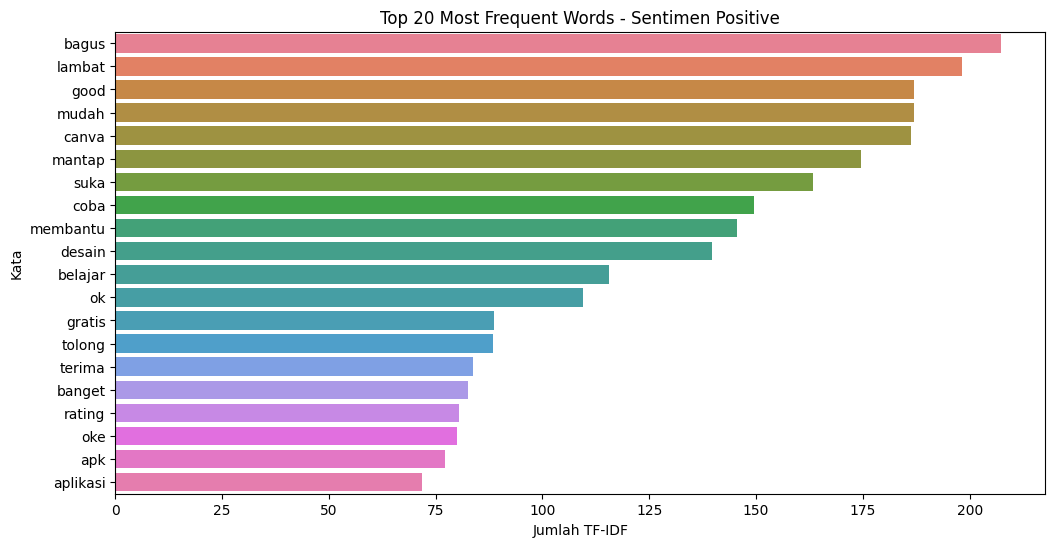

In [55]:
# Menampilkan barplot untuk most frequent word sentimen postif
plot_top_tfidf_words(review_canva_df, 'positive')

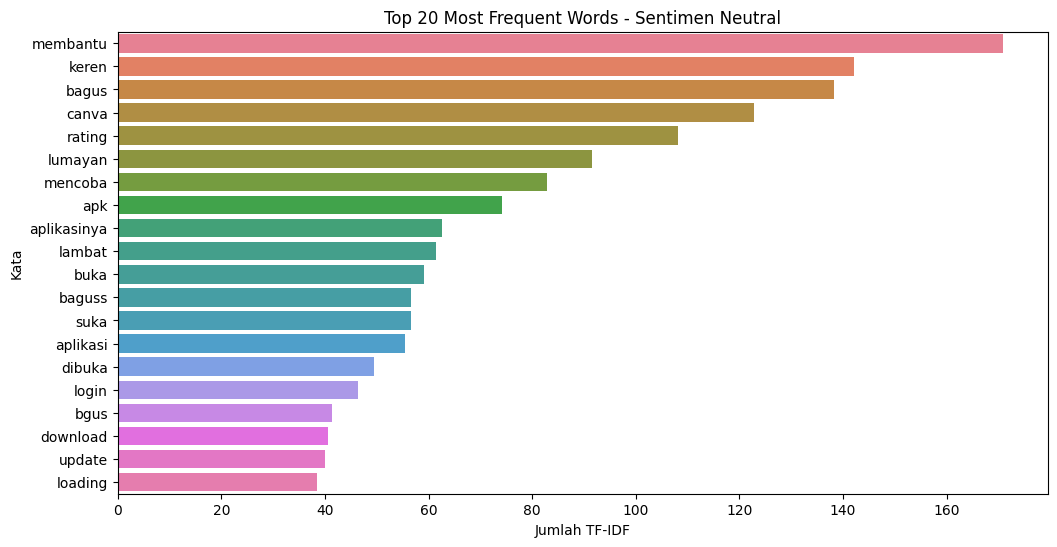

In [56]:
# Menampilkan barplot untuk most frequent word sentimen neutral
plot_top_tfidf_words(review_canva_df, 'neutral')

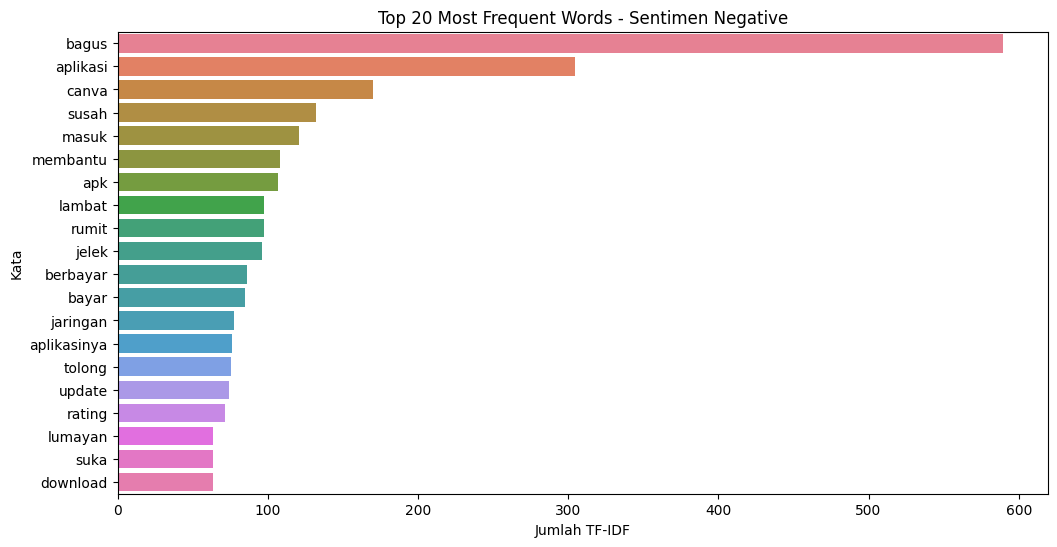

In [57]:
# Menampilkan barplot untuk most frequent word sentimen negatif
plot_top_tfidf_words(review_canva_df, 'negative')

## **Data Preparation**

In [58]:
# Pisahkan fitur (X) dan target (y)
X = review_canva_df['text_akhir']
y = review_canva_df['polarity']

In [59]:
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded = pad_sequences(sequences, maxlen=max_len, padding='post')

# Label Encoding
encoder = LabelEncoder()
labels = encoder.fit_transform(y)


### **Data Splitting**

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    padded, labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

### **Callbacks**

In [61]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

## **Skema 1: biLSTM dengan Tokenizer - 80/30 split**

In [62]:
# 1. Bangun model
model_biLSTM = Sequential([
    Embedding(max_words, 256, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.0001))),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# 2. Kompilasi Model
model_biLSTM.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# 3. Hitung bobot
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# 4. Training
biLSTM = model_biLSTM.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7382 - loss: 0.6809 - val_accuracy: 0.8681 - val_loss: 0.4994 - learning_rate: 0.0010
Epoch 2/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9081 - loss: 0.2778 - val_accuracy: 0.8472 - val_loss: 0.4466 - learning_rate: 0.0010
Epoch 3/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9488 - loss: 0.1637 - val_accuracy: 0.7608 - val_loss: 0.5968 - learning_rate: 0.0010
Epoch 4/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9644 - loss: 0.1321 - val_accuracy: 0.8947 - val_loss: 0.4184 - learning_rate: 0.0010
Epoch 5/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9690 - loss: 0.1149 - val_accuracy: 0.8917 - val_loss: 0.4263 - learning_rate: 0.0010
Epoch 6/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9718 - loss: 0.1059
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9718 - loss: 0.1059 - va

In [63]:
# Prediksi label pada test set
y_pred_probs = model_biLSTM.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

# Akurasi
train_acc = model_biLSTM.evaluate(X_train, y_train, verbose=0)[1]
test_acc = accuracy_score(y_test, y_pred)

print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Train Accuracy:  0.9950694441795349
Test Accuracy:  0.9033333333333333

Classification Report:
              precision    recall  f1-score   support

    negative       0.93      0.89      0.91      1135
     neutral       0.86      0.90      0.88      1258
    positive       0.93      0.91      0.92      1207

    accuracy                           0.90      3600
   macro avg       0.91      0.90      0.90      3600
weighted avg       0.90      0.90      0.90      3600



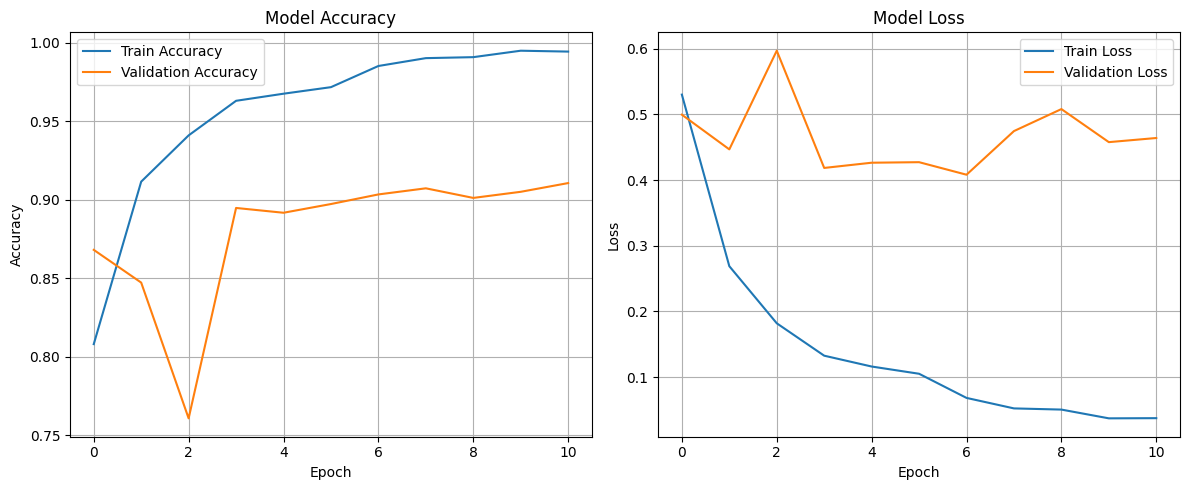

In [64]:
# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(biLSTM.history['accuracy'], label='Train Accuracy')
plt.plot(biLSTM.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(biLSTM.history['loss'], label='Train Loss')
plt.plot(biLSTM.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## **Skema 2: CNN1D dengan Tokenizer - 80/20 split**

In [65]:
# 1. Bangun model CNN + BiLSTM
model_cnn = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

# 2. Kompilasi Model
model_cnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Hitung class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# 3. Training dengan Data Augmentasi (Opsional)
modelCnn = model_cnn.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4649 - loss: 1.8194 - val_accuracy: 0.5667 - val_loss: 0.9647 - learning_rate: 0.0010
Epoch 2/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8021 - loss: 0.5681 - val_accuracy: 0.8603 - val_loss: 0.4295 - learning_rate: 0.0010
Epoch 3/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8908 - loss: 0.3466 - val_accuracy: 0.8814 - val_loss: 0.3705 - learning_rate: 0.0010
Epoch 4/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9168 - loss: 0.2607 - val_accuracy: 0.8828 - val_loss: 0.3566 - learning_rate: 0.0010
Epoch 5/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9311 - loss: 0.2346 - val_accuracy: 0.8872 - val_loss: 0.3640 - learning_rate: 0.0010
Epoch 6/30
440/450 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9460 - loss: 0.1883
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9459 - loss: 0.1885 - val_accurac

In [66]:
# Prediksi label pada test set
y_pred_probs = model_cnn.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

# Akurasi
train_acc = model_cnn.evaluate(X_train, y_train, verbose=0)[1]
test_acc = accuracy_score(y_test, y_pred)

print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Train Accuracy:  0.9817361235618591
Test Accuracy:  0.8897222222222222

Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.90      0.90      1135
     neutral       0.85      0.86      0.85      1258
    positive       0.92      0.91      0.91      1207

    accuracy                           0.89      3600
   macro avg       0.89      0.89      0.89      3600
weighted avg       0.89      0.89      0.89      3600



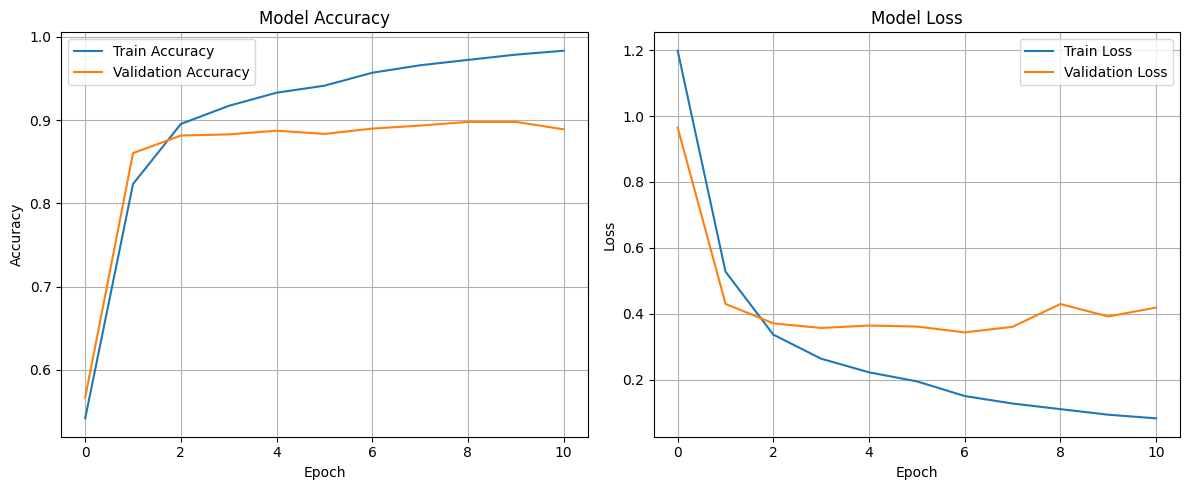

In [67]:
# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(modelCnn.history['accuracy'], label='Train Accuracy')
plt.plot(modelCnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(modelCnn.history['loss'], label='Train Loss')
plt.plot(modelCnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### **Skema 3: biGRU dengan Tokenizer - 80/30 split**

In [68]:
# 1. Bangun model biGRU
model_biGRU = Sequential([
    Embedding(max_words, 256, input_length=max_len),
    Bidirectional(GRU(128, return_sequences=True, kernel_regularizer=l2(0.001))),
    BatchNormalization(),
    Bidirectional(GRU(64, return_sequences=True, kernel_regularizer=l2(0.001))),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# 2. Kompilasi Model
model_biGRU.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Hitung class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# 3. Training dengan Data Augmentasi (Opsional)
modelbiGRu = model_biGRU.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.7154 - loss: 1.2354 - val_accuracy: 0.4078 - val_loss: 1.2352 - learning_rate: 0.0010
Epoch 2/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.9156 - loss: 0.3823 - val_accuracy: 0.3525 - val_loss: 8.6179 - learning_rate: 0.0010
Epoch 3/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9402 - loss: 0.2414
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9402 - loss: 0.2413 - val_accuracy: 0.3503 - val_loss: 5.5596 - learning_rate: 0.0010
Epoch 4/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.9647 - loss: 0.1538 - val_accuracy: 0.8531 - val_loss: 0.7551 - learning_rate: 5.0000e-04
Epoch 5/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9762 - loss: 0.1085 - val_accuracy: 0.7647 - val_loss: 1.1311 - learning_rate: 5.0000e-04
Epoch 6/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9819 - loss: 

In [69]:
# Prediksi label pada test set
y_pred_probs = model_biGRU.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

# Akurasi
train_acc3 = model_biGRU.evaluate(X_train, y_train, verbose=0)[1]
test_acc3 = accuracy_score(y_test, y_pred)

print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Train Accuracy:  0.9817361235618591
Test Accuracy:  0.8897222222222222

Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.90      0.92      1135
     neutral       0.80      0.94      0.86      1258
    positive       0.97      0.83      0.89      1207

    accuracy                           0.89      3600
   macro avg       0.90      0.89      0.89      3600
weighted avg       0.90      0.89      0.89      3600



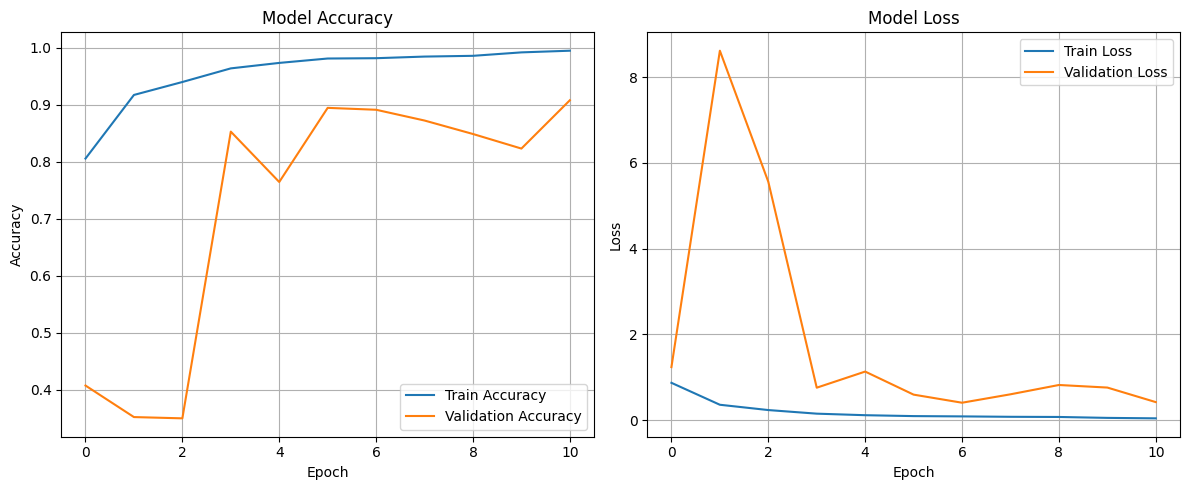

In [70]:
# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(modelbiGRu.history['accuracy'], label='Train Accuracy')
plt.plot(modelbiGRu.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(modelbiGRu.history['loss'], label='Train Loss')
plt.plot(modelbiGRu.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [74]:
!pip freeze > requirements.txt